# 1. Load Datasets

## 1.1 Load Annotations

In [1]:
import os
import cv2
import json
import torch
import tqdm
import numpy as np
import pandas as pd

from captum.attr import visualization

from matplotlib import pyplot as plt

In [2]:
annotation_folder = "/opt/datasets/mmf/datasets/hateful_memes/defaults/annotations/fine_grained"

image_folder = "/opt/datasets/mmf/datasets/hateful_memes/defaults/images"
features_folder = "/opt/datasets/mmf/datasets/hateful_memes/defaults/features/clean/"

In [3]:
annotations_df = pd.read_json(os.path.join(annotation_folder, "dev_seen.json"), lines=True)
annotations_df.head()

,id,set_name,img,text,gold_hate,gold_pc,gold_attack,pc,attack
0,5349,dev_seen,img/05349.png,normal day in a islamic country,[not_hateful],[pc_empty],[attack_empty],None,None
1,17265,dev_seen,img/17265.png,meanwhile in baltimore,[not_hateful],[pc_empty],[attack_empty],None,None
2,91405,dev_seen,img/91405.png,wears rag on her head so her brother husband d...,[not_hateful],[pc_empty],[attack_empty],None,None
3,83497,dev_seen,img/83497.png,different types of radicalization,[not_hateful],[pc_empty],[attack_empty],None,None
4,4569,dev_seen,img/04569.png,when is the time to eat i am hungry,[not_hateful],[pc_empty],[attack_empty],None,None


## 1.2 Utils Functions

In [4]:
colors = np.array([
    [167,  30,  74],
    [125,  58, 151],
    [ 72,  50, 144],
    [ 29, 146, 198],
    [ 99, 178,  71],
    [206, 222,  53],
    [243, 238,  60],
    [250, 187,  24],
    [243,  85,  36]
]).astype(float)

In [5]:
def get_filepaths(model, sample):
    prediction_dir = f"../model_outputs/{model}"
    
    return {
        "text_gradients": f"{prediction_dir}/text/{sample}_text_gradients.npy",
        "text_metadata": f"{prediction_dir}/text/{sample}_text_metadata.npy",
        "img_gradient": f"{prediction_dir}/img/{sample}_img_gradients.npy",
        "cross_attentions": f"{prediction_dir}/cross_modality/{sample}_attentions.npy"
    }

In [6]:
with open("../visual_genome_categories.json") as f:
    data = json.load(f)
    
categories_dict = {d['id']: d['name'] for d in data['categories']}

In [7]:
def load_npy(filename, allow_pickle=False):
    with open(filename, 'rb') as f:
        data = np.load(f, allow_pickle=allow_pickle)
        
    return data

def load_json(filename):
    with open(filename) as f:
        data = json.load(f)
        
    return data    

In [8]:
def process_attribution(attrs):
    attrs = attrs.sum(axis=2).squeeze(0)
    attrs = attrs / np.linalg.norm(attrs)
    
    return attrs

# 2. Examine the individual component and cross-component for one sample

## 2.1 Examine Textual Data

In [9]:
sample = 7528
fps = get_filepaths("visual_bert_coco", sample)

In [10]:
text_gradients, metadata = load_npy(fps['text_gradients']), load_json(fps['text_metadata'])
text_gradients.shape

(1, 128, 768)

In [11]:
metadata

{'pred_probs': 0.9691146612167358,
 'pred_class': 'Hateful',
 'true_class': 'Hateful',
 'attr_class': 'Hateful',
 'raw_input': ['[CLS]',
  'the',
  'latest',
  'and',
  'greatest',
  '.',
  'a',
  'truck',
  'that',
  'comes',
  'with',
  'a',
  'dish',
  '##wash',
  '##er',
  '!',
  '[SEP]'],
 'convergence_score': 0.009316821876360848}

In [12]:
text_gradients = process_attribution(text_gradients)
text_gradients = text_gradients[:len(metadata['raw_input'])]

In [13]:
records = [visualization.VisualizationDataRecord(
    text_gradients,
    metadata['pred_probs'],
    metadata['pred_class'],
    metadata['true_class'],
    metadata['attr_class'],
    text_gradients.sum(),
    metadata['raw_input'],
    metadata['convergence_score'])
]

In [14]:
print('Visualize attributions based on Integrated Gradients')
_ = visualization.visualize_text(records)

Visualize attributions based on Integrated Gradients


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
Hateful,Hateful (0.97),Hateful,1.51,[CLS] the latest and greatest . a truck that comes with a dish ##wash ##er ! [SEP]


In [15]:
text_gradients.sum()

1.513131648495187

## 2.2 Examine Image Data

### 2.2.1 Load Original Image

In [16]:
def load_img(filename):
    img_filepath = os.path.join(image_folder, 'img', filename)
    img = cv2.imread(img_filepath)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

(366, 550, 3)


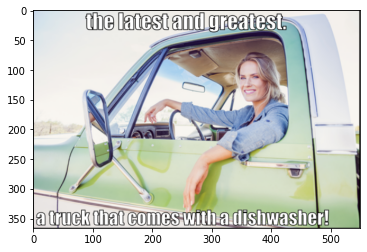

In [17]:
sample_filename = f"{sample:05}.png"
img = load_img(sample_filename)
print(img.shape)
plt.imshow(img)

### 2.2.2 Get Image Segments

In [18]:
def get_features(sample):
    feature_dir = "/opt/datasets/mmf/datasets/hateful_memes/defaults/features/clean"
    
    return {
        "features": os.path.join(feature_dir, f"{sample:05}.npy"),
        "features_info": os.path.join(feature_dir, f"{sample:05}_info.npy")
    }

In [19]:
feature_fps = get_features(sample)
img_gradients = load_npy(fps['img_gradient'], True)

img_features = np.load(feature_fps['features'], allow_pickle=True)
img_info = np.load(feature_fps['features_info'], allow_pickle=True).item()

In [20]:
assert img.shape[0] == img_info['image_height']
assert img.shape[1] == img_info['image_width']
assert img_features.shape == img_gradients.shape

In [21]:
print(img_features.shape, img_gradients.shape)
img_info.keys()

(100, 2048) (100, 2048)


dict_keys(['image_id', 'bbox', 'num_boxes', 'image_height', 'image_width', 'objects', 'cls_prob'])

In [22]:
def sort_image_gradients(gradients):
    # Take the average across all dimensions
    gradients = gradients.mean(axis=1)
    
    # Sort the img gradients by the magnitude of the attribution scores
    indices = sorted(range(len(gradients)), key=lambda i: gradients[i], reverse=True)
    
    return indices

top_k_indices = sort_image_gradients(img_gradients)
top_k_indices[:9]

[0, 52, 16, 84, 26, 65, 15, 27, 55]

In [23]:
print("image coverage @ 9:", img_gradients[top_k_indices][:9].sum() / img_gradients.sum())
print("image coverage @ 10:", img_gradients[top_k_indices][:10].sum() / img_gradients.sum())
print("image coverage @ 20:", img_gradients[top_k_indices][:20].sum() / img_gradients.sum())

image coverage @ 9: 0.34217823
image coverage @ 10: 0.36905083
image coverage @ 20: 0.5479122


In [24]:
img_info['bbox'][top_k_indices[:9]]

array([[338.4288  ,  93.10624 , 423.26428 , 155.92975 ],
       [346.24542 ,  73.892296, 434.5579  , 177.2759  ],
       [347.0916  ,  73.98327 , 394.159   , 150.32053 ],
       [326.3748  ,  74.64304 , 420.80264 , 174.56622 ],
       [311.76117 ,  65.38648 , 438.244   , 239.92715 ],
       [ 61.401314, 193.26149 , 217.35733 , 324.76224 ],
       [341.6277  ,  85.02476 , 387.80664 , 149.80487 ],
       [  0.      , 133.05434 , 295.98865 , 325.6055  ],
       [318.8409  ,  55.98458 , 425.4543  , 156.196   ]], dtype=float32)

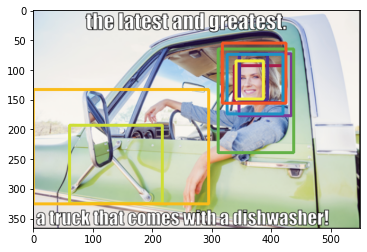

In [25]:
def draw_bboxes(img, bounding_boxes: list):
    image = img.copy()
    for idx, (box, color) in enumerate(zip(bounding_boxes, colors)):
        top_left, bottom_right = box[:2].astype(int), box[2:].astype(int)
        image = cv2.rectangle(image, tuple(top_left), tuple(bottom_right), tuple(color), 3)
    
    return image
        
image = draw_bboxes(img, img_info['bbox'][top_k_indices[:9]])
plt.imshow(image)

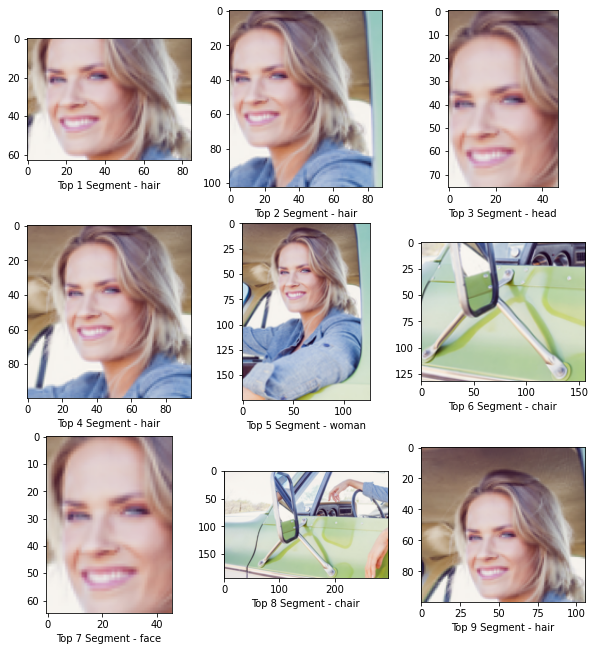

In [26]:
def crop_img_segments(image, indices):        
    fig = plt.figure(figsize=(10, 15))
    
    segments = []
    for (xmin, ymin, xmax, ymax), cat in zip(img_info['bbox'], img_info['objects']):
        xmin, ymin = round(xmin), round(ymin)
        xmax, ymax = round(xmax), round(ymax)

        segments.append((image[ymin:ymax, xmin:xmax], categories_dict[cat]))

    for idx, i in enumerate(indices):
        segment_i, segment_cls = segments[i]

        if len(segment_i) == 0:
            segment_i = np.array([[0]])
            segment_cls += "(out of bounds)"

        ax = fig.add_subplot(4, 3, idx+1)
        ax.imshow(segment_i)
        ax.set_xlabel('Top {} Segment - {}'.format(idx + 1, segment_cls))
        
crop_img_segments(img, top_k_indices[:9])

## 2.3 Cross-Modality Examination

### 2.3.1 Load Attention Weights

In [27]:
attention_weights = load_npy(fps['cross_attentions'])
attention_weights.shape

(12, 1, 12, 228, 228)

### 2.3.2 Visualise

In [28]:
import string
def visualize_token2token_scores(scores_mat, sentence, bounding_boxes, x_label_name='Head', layer=0):
    fig = plt.figure(figsize=(20, 20))
    
    sentence_indices, sentence_filtered = [], []
    for idx, token in enumerate(sentence):
        if token not in string.punctuation:
            sentence_indices.append(idx)
            sentence_filtered.append(token)
    
    visual_indices = [x + 128 for x in bounding_boxes]
    
    
    row_indices = visual_indices
    col_indices = sentence_indices
    
    row_axis = [f"{x}" for x in range(1, len(bounding_boxes) + 1)]
    col_axis = sentence_filtered
    
    # indices = list(range(start, start + len(sent))) + [x + 128 for x in top_k_indices]
    # indices = sentence_indices + visual_indices
    # axis = sentence_filtered + [f"segment_{x}" for x in range(1, len(top_k_indices) + 1)]

    for idx, scores in enumerate(scores_mat):
        scores_np = np.array(scores)

        scores_np = scores_np[row_indices]
        scores_np = scores_np[:, col_indices]
        
        ax = fig.add_subplot(4, 3, idx+1)
        
        # append the attention weights
        im = ax.imshow(scores_np.T, cmap='viridis', vmin=0, vmax=1)

        fontdict = {'fontsize': 12}

        ax.set_xticks(range(len(row_axis)))
        ax.set_yticks(range(len(col_axis)))

        ax.set_xticklabels(row_axis, fontdict=fontdict, rotation=90)
        ax.set_yticklabels(col_axis, fontdict=fontdict)
        
        if x_label_name == 'Heads':
            ax.set_xlabel('{} {} - {} {}'.format('Layer', 12 - layer, x_label_name, 12 - idx))
        else:
            ax.set_xlabel('{} {}'.format(x_label_name, 12 - idx))

        fig.colorbar(im, fraction=0.046, pad=0.04)
        
    plt.tight_layout()
    plt.show()

In [29]:
if torch.__version__ >= '1.7.0':
    norm_fn = np.linalg.norm
else:
    norm_fn = np.norm

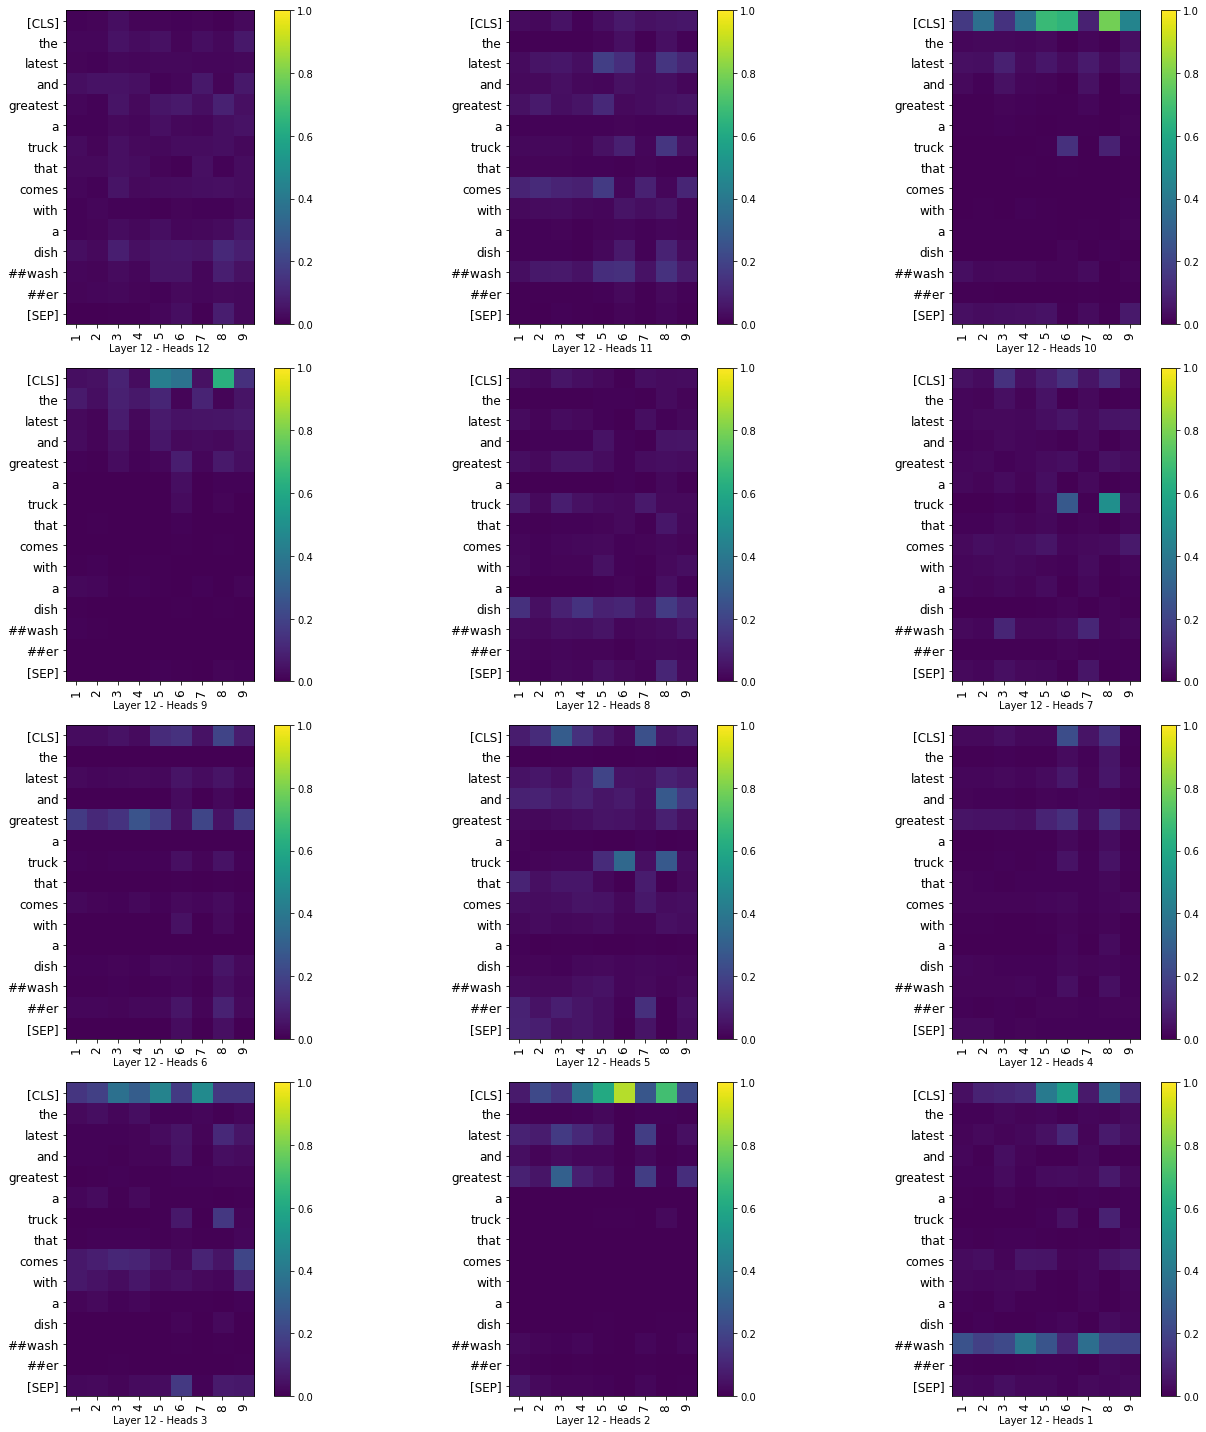

In [30]:
layer = 0
visualize_token2token_scores(attention_weights[layer].squeeze(),
                             metadata['raw_input'],
                             bounding_boxes=top_k_indices[:9],
                             x_label_name='Heads',
                             layer=layer)

In [31]:
import string
def visualize_token2token_scores_individual(scores_mat, head, sentence, bounding_boxes, x_label_name='Head', layer=0):
    fig = plt.figure(figsize=(5, 10))
    
    sentence_indices, sentence_filtered = [], []
    for idx, token in enumerate(sentence):
        if token not in string.punctuation:
            sentence_indices.append(idx)
            sentence_filtered.append(token)
    
    visual_indices = [x + 128 for x in bounding_boxes]
    
    # Indices
    row_indices = visual_indices
    col_indices = sentence_indices
    
    row_axis = [f"{x}" for x in range(1, len(bounding_boxes) + 1)]
    col_axis = sentence_filtered

    scores_np = np.array(scores_mat[12 - head])
    scores_np = scores_np[row_indices]
    scores_np = scores_np[:, col_indices]
        
    ax = fig.add_subplot(1, 1, 1)
        
    # append the attention weights
    im = ax.imshow(scores_np.T, cmap='viridis', vmin=0, vmax=1)

    fontdict = {'fontsize': 18}

    ax.set_xticks(range(len(row_axis)))
    ax.set_yticks(range(len(col_axis)))

    ax.set_xticklabels(row_axis, fontdict=fontdict, rotation=90)
    ax.set_yticklabels(col_axis, fontdict=fontdict)

    if x_label_name == 'Heads':
        fig_name = '{} {} - {} {}'.format('Layer', 12 - layer, x_label_name, head)
    else:
        fig_name = '{} {}'.format(x_label_name, 12 - idx)
    
    ax.set_xlabel(fig_name)
    fig.colorbar(im, fraction=0.046, pad=0.04)
        
    plt_name = '{} {}'.format(sample, fig_name)
    plt.tight_layout()
    plt.savefig(plt_name)
    
    plt.show()

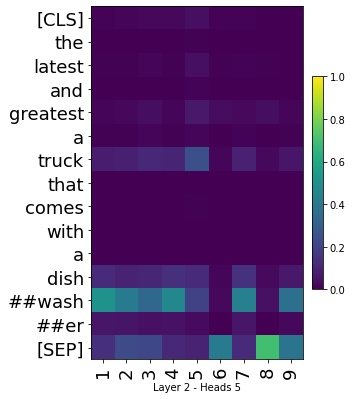

In [32]:
layer = 10
tmp = attention_weights[layer].squeeze()

visualize_token2token_scores_individual(tmp, 5,
                                        metadata['raw_input'],
                                        bounding_boxes=top_k_indices[:9],
                                        x_label_name='Heads',
                                        layer=layer)

# 3. Truncated Version (For Easier Visualisation and Exploration)

### 3.1.1 Load sample information

In [47]:
sample = 80597
sample_filename = f"{sample:05}.png"

fps = get_filepaths("visual_bert_coco", sample)
feature_fps = get_features(sample)

### 3.1.2 Prepare image gradients

In [50]:
img = load_img(sample_filename)

In [51]:
img_gradients = load_npy(fps['img_gradient'], True)
img_features = np.load(feature_fps['features'], allow_pickle=True)
img_info = np.load(feature_fps['features_info'], allow_pickle=True).item()

img_bboxes = img_info['bbox']

In [52]:
assert img.shape[0] == img_info['image_height']
assert img.shape[1] == img_info['image_width']
assert img_features.shape == img_gradients.shape

In [53]:
top_k_indices = sort_image_gradients(img_gradients)

### 3.1.3 Prepare cross-modality attention weights

In [54]:
attention_weights = load_npy(fps['cross_attentions'])
attention_weights.shape

(12, 1, 12, 228, 228)

### 3.1.4 Visualise and explore

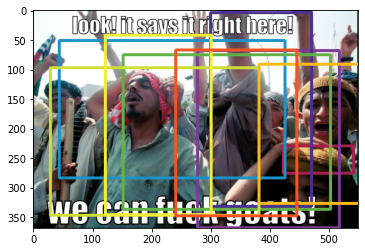

In [55]:
images_bb = draw_bboxes(img, img_bboxes[top_k_indices[:9]])
plt.imshow(images_bb)

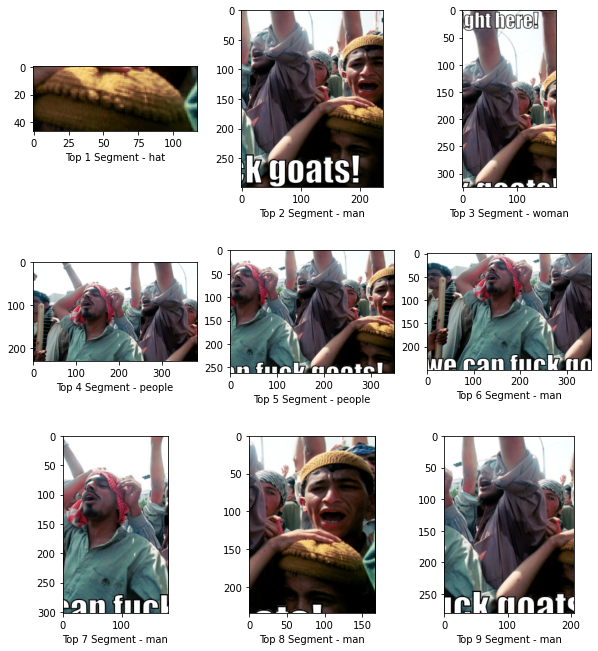

In [56]:
crop_img_segments(img, top_k_indices[:9])

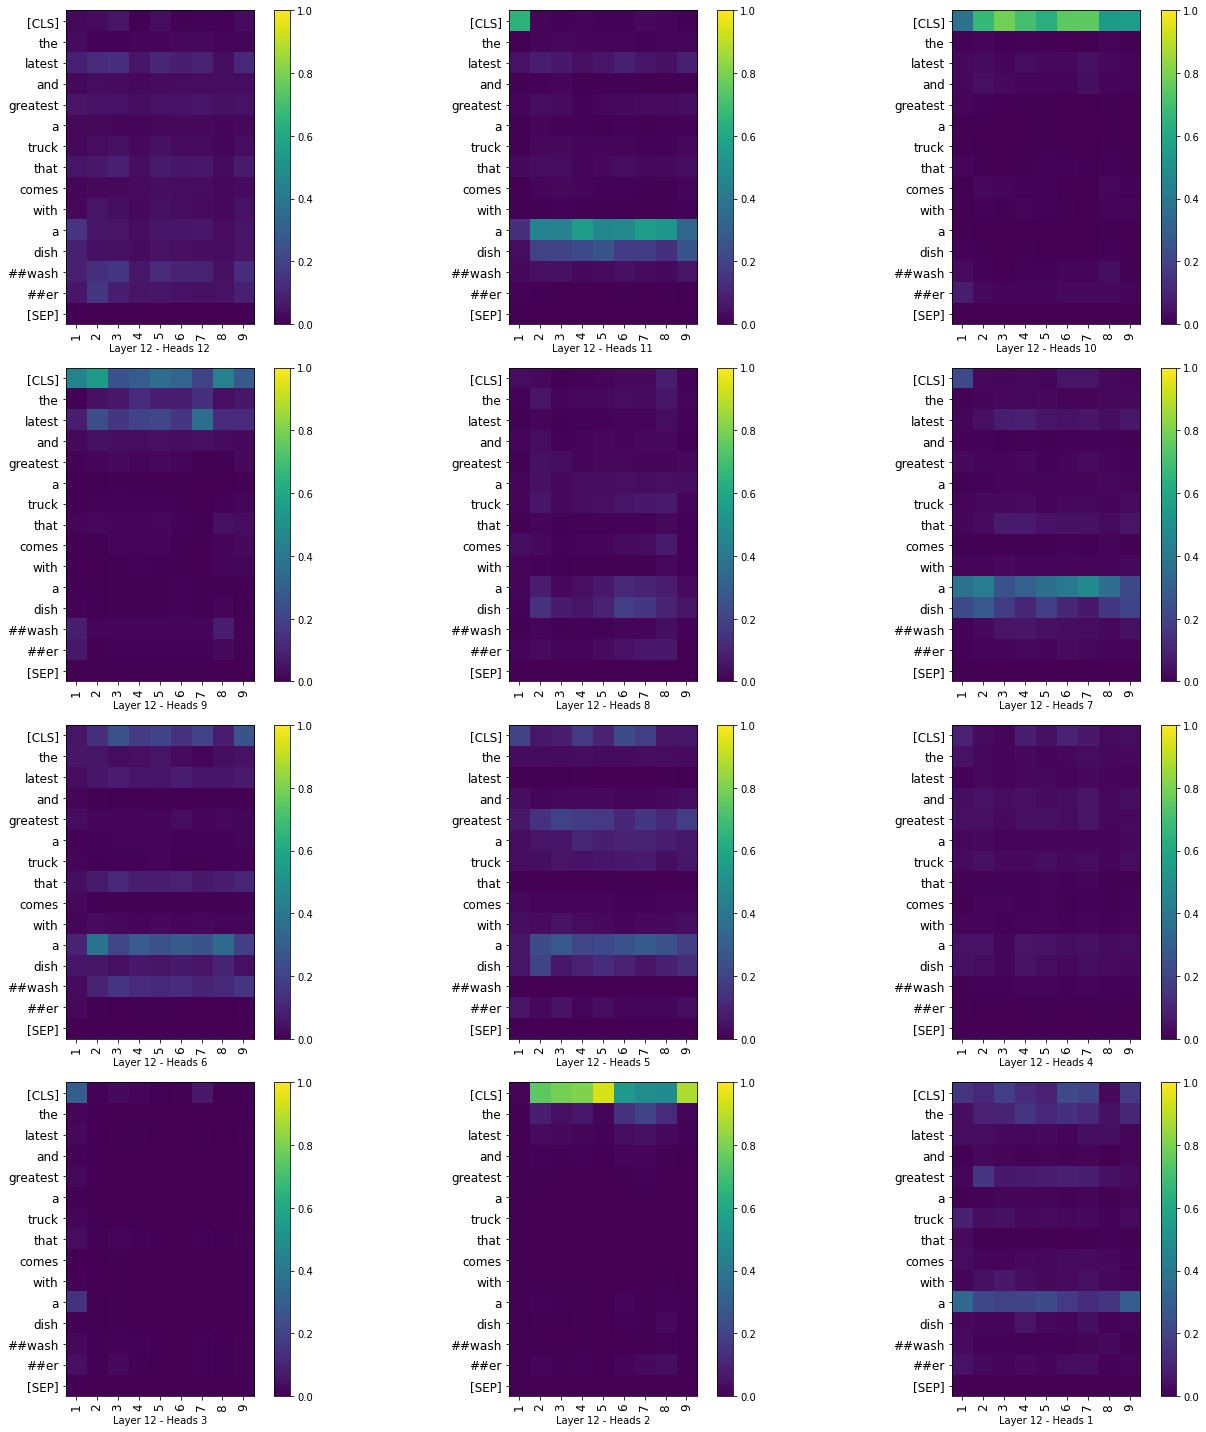

In [57]:
layer = 0
visualize_token2token_scores(attention_weights[layer].squeeze(),
                             metadata['raw_input'],
                             bounding_boxes=top_k_indices[:9],
                             x_label_name='Heads',
                             layer=layer)